


Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

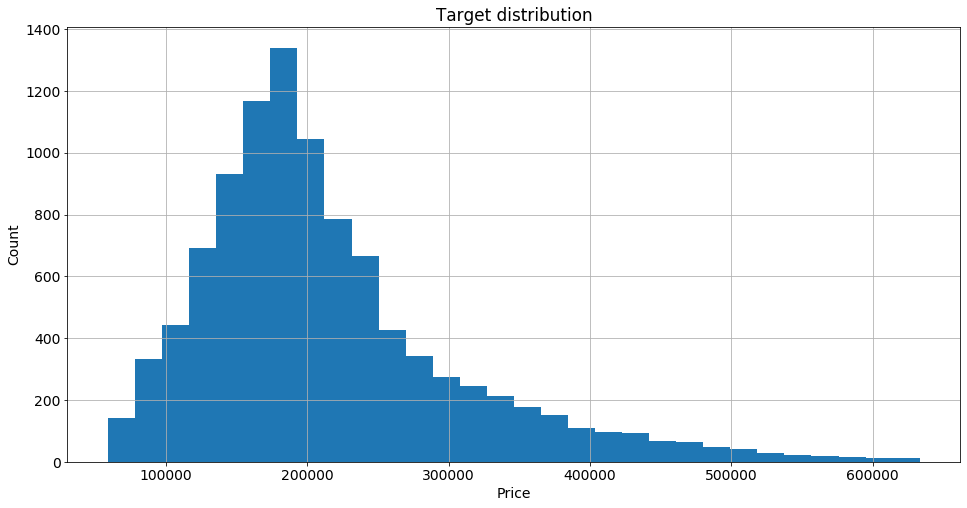

In [11]:
plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [13]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [14]:
train_df['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [15]:
train_df['Ecology_2'].value_counts().head()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
train_df['Ecology_3'].value_counts().head()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
train_df['Shops_2'].value_counts().head()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

**Rooms**

In [18]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [19]:
train_df.loc[train_df['Rooms'].isin([0,10,19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

(array([1.200e+01, 1.000e+00, 9.000e+00, 2.300e+01, 3.270e+02, 1.305e+03,
        2.086e+03, 1.208e+03, 1.186e+03, 1.193e+03, 7.090e+02, 5.650e+02,
        6.790e+02, 2.790e+02, 1.070e+02, 1.080e+02, 6.500e+01, 2.600e+01,
        3.700e+01, 2.100e+01, 1.100e+01, 1.400e+01, 2.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

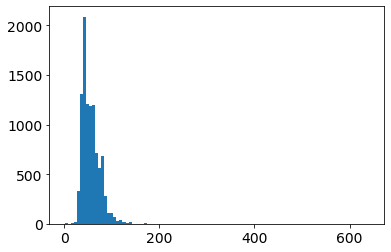

In [20]:
plt.hist(train_df['Square'], bins = 100)

(array([7.59e+03, 2.82e+02, 9.00e+00, 2.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

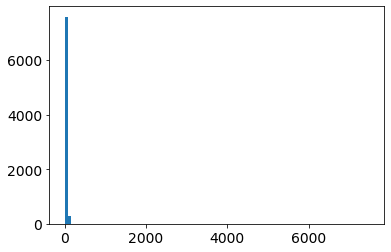

In [21]:
plt.hist(train_df['LifeSquare'], bins = 100)

(array([9.952e+03, 2.100e+01, 1.300e+01, 7.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

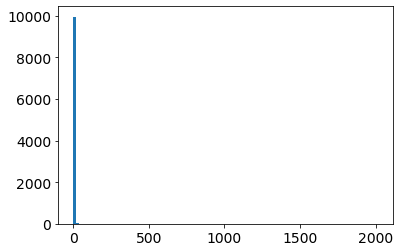

In [22]:
plt.hist(train_df['KitchenSquare'], bins = 100)

In [23]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.975)) |
                    (train_df['Square'] > train_df['Square'].quantile(.025))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.775)) |
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

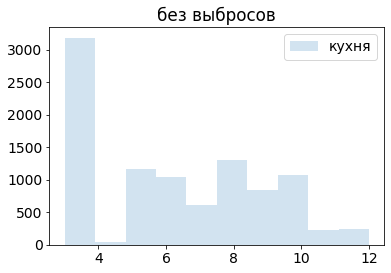

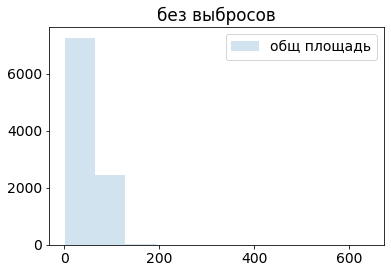

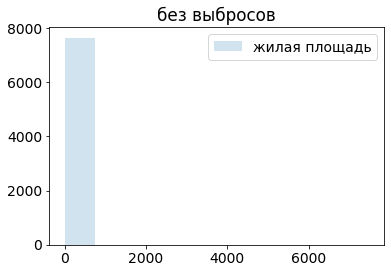

In [24]:
plt.hist(train_df['KitchenSquare'], bins = 10, alpha = 0.2, label = 'кухня')
plt.legend()
plt.title('без выбросов')
plt.show()
plt.hist(train_df['Square'], bins = 10, alpha = 0.2, label = 'общ площадь')
plt.legend()
plt.title('без выбросов')
plt.show()
plt.hist(train_df['LifeSquare'], bins = 10, alpha = 0.2, label = 'жилая площадь')
plt.legend()
plt.title('без выбросов')
plt.show()

In [25]:
train_df = train_df[(train_df['LifeSquare'] < 6000)]

**HouseFloor, Floor**

In [26]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  27.,  28.,  29.,  30.,  32.,  37.,  38.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [27]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [28]:
train_df.loc[train_df['HouseFloor']==0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [29]:
floor_outliers =train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [30]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
7076        2020
5701        2020
3859        2020
          ...   
5016        1918
1380        1917
5053        1917
8144        1917
910         1914
Name: HouseYear, Length: 7641, dtype: int64

In [31]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2019

### Обработка пропусков

In [32]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     3313
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**Healthcare_1**

In [33]:
train_df[['Healthcare_1','Helthcare_2']]

,Healthcare_1,Helthcare_2
0,NaN,0
1,240.0,1
2,229.0,1
3,1084.0,0
4,2078.0,2
...,...,...
9993,NaN,5
9995,350.0,3
9996,NaN,0
9998,325.0,2


In [34]:
train_df.drop(['Healthcare_1'], axis=1, inplace = True)

In [35]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000
mean,1.909829,54.328134,35.794003,6.965188,7.156655,12.403874,1985.171836,0.123349,28.696375,6136.836932,7.282686,1.531344,4.567727,221419.208673
std,0.816299,19.152875,19.719228,2.517653,4.821194,6.135636,19.266182,0.120546,16.602520,3906.084966,19.682245,1.509427,4.434680,92166.970247
min,1.000000,1.136859,0.370619,3.000000,1.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,40.954448,22.698481,5.000000,3.000000,9.000000,1970.000000,0.025609,19.000000,3806.000000,1.000000,0.000000,1.000000,162068.447953
50%,2.000000,49.893205,32.525213,7.000000,6.000000,12.000000,1979.000000,0.087619,28.000000,5664.000000,2.000000,1.000000,4.000000,199367.910657
75%,2.000000,64.009231,44.763919,9.000000,10.000000,17.000000,2003.000000,0.195781,39.000000,7759.000000,5.000000,3.000000,6.000000,259899.295150
max,6.000000,641.065193,638.163193,12.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,625678.644994


**LifeSquare**

In [36]:
train_df['Square'].median()

49.893205105180904

In [37]:
train_df.loc[train_df['Square']<(train_df['LifeSquare'] + train_df['KitchenSquare'])].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
14,10953,27,1.0,53.769097,52.408027,3.0,2,4.0,1977,0.072158,B,B,2,629,1,0,0,A,140647.565937
28,8054,23,1.0,42.530043,43.967759,3.0,3,9.0,2014,0.034656,B,B,0,168,0,0,0,B,95338.198549
42,9833,1,2.0,56.494318,54.723569,3.0,9,17.0,1977,0.007122,B,B,1,264,0,0,1,B,196078.907289
44,10521,38,3.0,104.211396,106.340403,3.0,8,12.0,2017,0.060753,B,B,15,2787,2,0,7,B,435462.048070


In [38]:
sq_diff = (train_df.loc[train_df['Square']>(train_df['LifeSquare']+train_df['KitchenSquare']), 'Square'] - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
sq_diff

12.230158419821382

In [39]:
train_df.loc[train_df['Square']<(train_df['LifeSquare']+train_df['KitchenSquare']), 'Square'] = \
train_df.loc[train_df['Square']<(train_df['LifeSquare']+train_df['KitchenSquare']), 'LifeSquare'] + \
train_df.loc[train_df['Square']<(train_df['LifeSquare']+train_df['KitchenSquare']), 'KitchenSquare'] +\
sq_diff

In [40]:
train_df['Square'].median()

53.55140764373775

### Построение новых признаков

**Dummies**

In [41]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [42]:
train_df['DistrictId'].unique()

array(['35', '41', '53', '58', '99', '59', '154', '23', '28', '31', '13',
       '57', '27', '85', '34', '19', '0', '48', '150', '11', '50', '61',
       '44', '90', '200', '43', '177', '101', '1', '38', '21', '103',
       '98', '170', '94', '5', '88', '47', '77', '74', '79', '6', '9',
       '156', '69', '108', '96', '169', '18', '128', '10', '144', '120',
       '39', '7', '84', '123', '159', '70', '129', '3', '95', '78', '45',
       '121', '49', '25', '2', '127', '56', '109', '46', '17', '62',
       '119', '52', '80', '86', '83', '91', '92', '118', '187', '36',
       '106', '161', '22', '63', '167', '113', '66', '29', '37', '20',
       '8', '181', '40', '54', '93', '30', '81', '107', '130', '100',
       '12', '125', '67', '26', '89', '24', '111', '138', '64', '124',
       '183', '55', '157', '151', '15', '87', '126', '155', '164', '105',
       '110', '33', '132', '71', '73', '189', '75', '122', '163', '141',
       '76', '115', '139', '143', '201', '165', '190', '193', '174'

In [43]:
train_df['DistrictId'].value_counts()

27     494
1      257
9      235
6      225
23     220
      ... 
196      1
117      1
209      1
207      1
174      1
Name: DistrictId, Length: 204, dtype: int64

In [44]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
.rename(columns = {'index': 'DistrictId', 'DistrictId' : 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,494
1,1,257
2,9,235
3,6,225
4,23,220


In [45]:
train_df = train_df.merge(district_size, on='DistrictId', how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,B,184966.930730,1,1,1,18
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,B,300009.450063,1,1,1,86
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,B,220925.908524,1,1,1,139
3,5809,58,2.0,73.961670,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,B,175616.227217,1,1,1,118
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,B,150226.531644,1,1,1,97


In [46]:
(train_df['DistrictSize']>100).value_counts()

False    5189
True     2452
Name: DistrictSize, dtype: int64

In [47]:
train_df['IsDistrictLarge']=(train_df['DistrictSize']>100).astype(int)

**MedPriceByDistrict**

In [48]:
med_price_by_district  = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
.rename(columns = {'Price': 'MedPriceByDistrict'})
med_price_by_district.head(500)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142172.907136
1,0,2.0,177320.999600
2,0,3.0,308098.189977
3,1,1.0,146922.936495
4,1,2.0,199911.705672
...,...,...,...
495,58,2.0,165020.938559
496,58,3.0,243370.810453
497,59,1.0,211669.405923
498,59,2.0,322481.297549


In [49]:
train_df = train_df.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,18,0,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,297041.145784
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,139,1,256548.077274
3,5809,58,2.0,73.961670,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,118,1,165020.938559
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,97,0,158539.052715


### Отбор признаков

In [50]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [51]:
feature_names = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'IsDistrictLarge']

target_name = 'Price'

### Разбиение на train и test

In [52]:
X = train_df[feature_names]
y = train_df[target_name]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [54]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

**Отложенная выборка**

Train R2:	0.956
Test R2:	0.694


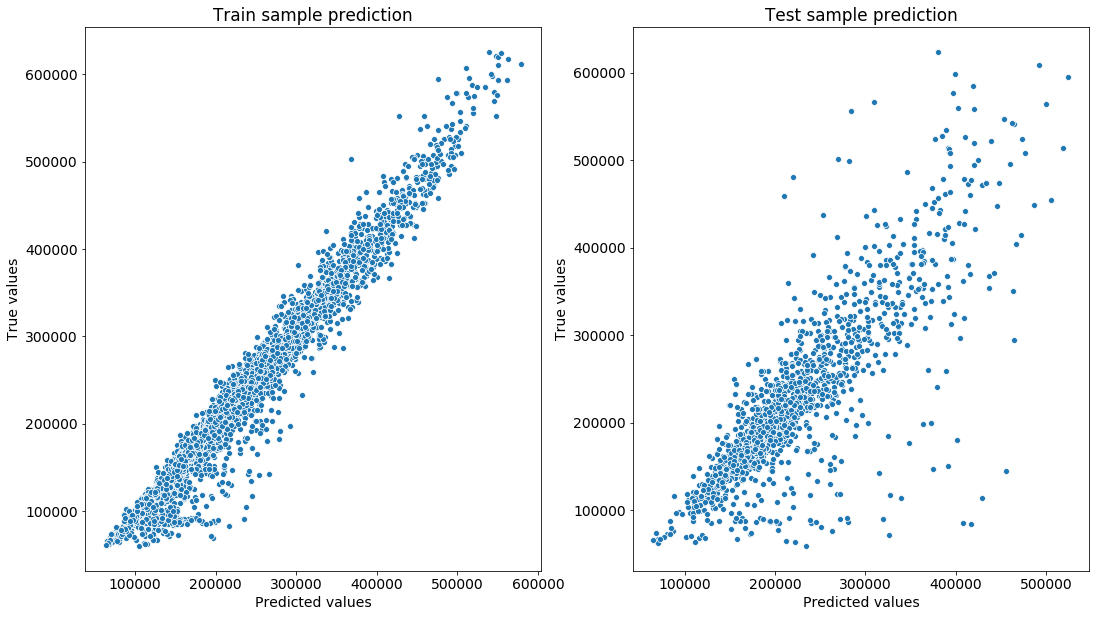

In [55]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [56]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.66484275, 0.69098368, 0.66735678])

In [57]:
cv_score.mean()

0.6743944025709135

**Важность признаков**

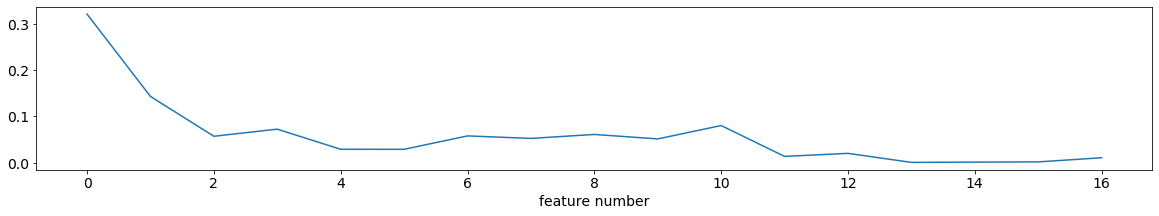

In [58]:
plt.figure(figsize=(20,3))
plt.plot(rf_model.feature_importances_)
plt.xlabel('feature number')
plt.show()

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [59]:
def my_feature(train_df = train_df, train_test = 0, 
               split_par = 0.2, kitch_size = 3,room_median = 2, 
               HouseFloor = 1, sq_diff = 10):
    
    train_df['Id'] = train_df['Id'].astype(str)
    train_df['DistrictId'] = train_df['DistrictId'].astype(str)
    train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = room_median
    
    train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = HouseFloor
    
    floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

    train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    
    train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2019
    
    train_df.drop(['Healthcare_1'], axis = 1, inplace = True)
    
    train_df.loc[train_df['Square']<(train_df['LifeSquare']+train_df['KitchenSquare']), 'Square'] =\
    train_df.loc[train_df['Square']<(train_df['LifeSquare']+train_df['KitchenSquare']), 'LifeSquare'] +\
    train_df.loc[train_df['Square']<(train_df['LifeSquare']+train_df['KitchenSquare']), 'KitchenSquare'] +\
    sq_diff
    train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.775)) |
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]
    train_df.loc[train_df['LifeSquare'].isnull(),'LifeSquare']=train_df['LifeSquare'].median()
    
    train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
    train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
    train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})
  
    
    district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    
    train_df = train_df.merge(district_size, on='DistrictId', how='left')
   
  
    
    train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
    

    feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
    ### ТУТ УДАЛИЛ MedPriceByDistrict так как иначе не работает
    new_feature_names = ['IsDistrictLarge']

    target_name = 'Price'
    X = train_df[feature_names + new_feature_names]
    X_train,y_train = [],[]
    X_test,y_test = X,[]
    if train_test==1: 
        y = train_df[target_name]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_par, shuffle=True, random_state=21)

    X_test =X_test.fillna(0)
    return X_train,y_train,X_test,y_test

# Разбиваем на train и test  тестовый датасет


In [60]:
X_traint,y_traint,X_testt,y_testt = my_feature(test_df, train_test = 0, 
                           split_par = 0.2, kitch_size = 3,room_median = 2, 
                           HouseFloor = 1, sq_diff = 10)


# Обучение и оценка модели

In [61]:
y_pred_test =rf_model.predict(X_testt)

In [62]:
preds = pd.DataFrame(y_pred_test, columns = ['PRICE'])
preds.index.name = 'number'
test_df2 = pd.read_csv(TEST_DATASET_PATH)
test_df2.index.name = 'number'
test_df2 = test_df2.merge(preds, on='number', how='left')
test_df2
PREDITIONS = test_df2[['Id', 'PRICE']]
PREDITIONS.set_index('Id',inplace=True)
PREDITIONS

,PRICE
Id,
725,189923.820409
15856,256838.878294
5480,254245.288708
15664,301366.321389
14275,117150.451901
...,...
8180,287862.949634
4695,96760.561627
5783,255744.704372


In [63]:
PREDITIONS.to_csv('PETROV_PREDICT', index = True)